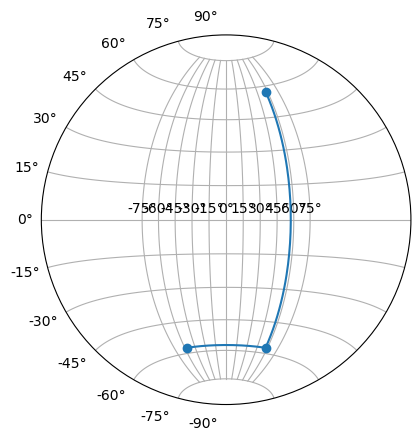

In [40]:
import numpy as np

import matplotlib
from matplotlib.axes import Axes
import matplotlib.axis as maxis
from matplotlib.patches import Circle
from matplotlib.path import Path
from matplotlib.projections import register_projection
import matplotlib.spines as mspines
from matplotlib.ticker import FixedLocator, Formatter, NullLocator
from matplotlib.transforms import Affine2D, BboxTransformTo, Transform

rcParams = matplotlib.rcParams

# This example projection class is rather long, but it is designed to
# illustrate many features, not all of which will be used every time.
# It is also common to factor out a lot of these methods into common
# code used by a number of projections with similar characteristics
# (see geo.py).


class GeoAxes(Axes):
    """
    An abstract base class for geographic projections
    """
    class ThetaFormatter(Formatter):
        """
        Used to format the theta tick labels.  Converts the native
        unit of radians into degrees and adds a degree symbol.
        """
        def __init__(self, round_to=1.0):
            self._round_to = round_to

        def __call__(self, x, pos=None):
            degrees = round(np.rad2deg(x) / self._round_to) * self._round_to
            return f"{degrees:0.0f}\N{DEGREE SIGN}"

    RESOLUTION = 75

    def _init_axis(self):
        self.xaxis = maxis.XAxis(self)
        self.yaxis = maxis.YAxis(self)
        # Do not register xaxis or yaxis with spines -- as done in
        # Axes._init_axis() -- until GeoAxes.xaxis.clear() works.
        # self.spines['geo'].register_axis(self.yaxis)

    def clear(self):
        # docstring inherited
        super().clear()

        self.set_longitude_grid(15)
        self.set_latitude_grid(15)
        self.set_longitude_grid_ends(75)
        self.xaxis.set_minor_locator(NullLocator())
        self.yaxis.set_minor_locator(NullLocator())
        self.xaxis.set_ticks_position('none')
        self.yaxis.set_ticks_position('none')
        self.yaxis.set_tick_params(label1On=True)
        # Why do we need to turn on yaxis tick labels, but
        # xaxis tick labels are already on?

        self.grid(rcParams['axes.grid'])

        Axes.set_xlim(self, -np.pi / 2.0, np.pi / 2.0)
        Axes.set_ylim(self, -np.pi / 2.0, np.pi / 2.0)

    def _set_lim_and_transforms(self):
        # A (possibly non-linear) projection on the (already scaled) data

        # There are three important coordinate spaces going on here:
        #
        # 1. Data space: The space of the data itself
        #
        # 2. Axes space: The unit rectangle (0, 0) to (1, 1)
        #    covering the entire plot area.
        #
        # 3. Display space: The coordinates of the resulting image,
        #    often in pixels or dpi/inch.

        # This function makes heavy use of the Transform classes in
        # ``lib/matplotlib/transforms.py.`` For more information, see
        # the inline documentation there.

        # The goal of the first two transformations is to get from the
        # data space (in this case longitude and latitude) to Axes
        # space.  It is separated into a non-affine and affine part so
        # that the non-affine part does not have to be recomputed when
        # a simple affine change to the figure has been made (such as
        # resizing the window or changing the dpi).

        # 1) The core transformation from data space into
        # rectilinear space defined in the HammerTransform class.
        self.transProjection = self._get_core_transform(self.RESOLUTION)

        # 2) The above has an output range that is not in the unit
        # rectangle, so scale and translate it so it fits correctly
        # within the Axes.  The peculiar calculations of xscale and
        # yscale are specific to an Aitoff-Hammer projection, so don't
        # worry about them too much.
        self.transAffine = self._get_affine_transform()

        # 3) This is the transformation from Axes space to display
        # space.
        self.transAxes = BboxTransformTo(self.bbox)

        # Now put these 3 transforms together -- from data all the way
        # to display coordinates.  Using the '+' operator, these
        # transforms will be applied "in order".  The transforms are
        # automatically simplified, if possible, by the underlying
        # transformation framework.
        self.transData = \
            self.transProjection + \
            self.transAffine + \
            self.transAxes

        # The main data transformation is set up.  Now deal with
        # gridlines and tick labels.

        # Longitude gridlines and ticklabels.  The input to these
        # transforms are in display space in x and Axes space in y.
        # Therefore, the input values will be in range (-xmin, 0),
        # (xmax, 1).  The goal of these transforms is to go from that
        # space to display space.  The tick labels will be offset 4
        # pixels from the equator.
        self._xaxis_pretransform = \
            Affine2D() \
            .scale(1.0, self._longitude_cap) \
            .translate(0.0, -self._longitude_cap)
        self._xaxis_transform = \
            self._xaxis_pretransform + \
            self.transData
        self._xaxis_text1_transform = \
            Affine2D().scale(1.0, 0.0) + \
            self.transData + \
            Affine2D().translate(0.0, 4.0)
        self._xaxis_text2_transform = \
            Affine2D().scale(1.0, 0.0) + \
            self.transData + \
            Affine2D().translate(0.0, -4.0)

        # Now set up the transforms for the latitude ticks.  The input to
        # these transforms are in Axes space in x and display space in
        # y.  Therefore, the input values will be in range (0, -ymin),
        # (1, ymax).  The goal of these transforms is to go from that
        # space to display space.  The tick labels will be offset 4
        # pixels from the edge of the Axes ellipse.
        yaxis_stretch = Affine2D().scale(np.pi*2, 1).translate(-np.pi, 0)
        yaxis_space = Affine2D().scale(1.0, 1.1)
        self._yaxis_transform = \
            yaxis_stretch + \
            self.transData
        yaxis_text_base = \
            yaxis_stretch + \
            self.transProjection + \
            (yaxis_space +
             self.transAffine +
             self.transAxes)
        self._yaxis_text1_transform = \
            yaxis_text_base + \
            Affine2D().translate(-8.0, 0.0)
        self._yaxis_text2_transform = \
            yaxis_text_base + \
            Affine2D().translate(8.0, 0.0)

    def _get_affine_transform(self):
        transform = self._get_core_transform(1)
        xscale, _ = transform.transform((np.pi, 0))
        _, yscale = transform.transform((0, np.pi/2))
        return Affine2D() \
            .scale(0.5 / xscale, 0.5 / yscale) \
            .translate(0.5, 0.5)

    def get_xaxis_transform(self, which='grid'):
        """
        Override this method to provide a transformation for the
        x-axis tick labels.

        Returns a tuple of the form (transform, valign, halign)
        """
        if which not in ['tick1', 'tick2', 'grid']:
            raise ValueError(
                "'which' must be one of 'tick1', 'tick2', or 'grid'")
        return self._xaxis_transform

    def get_xaxis_text1_transform(self, pad):
        return self._xaxis_text1_transform, 'bottom', 'center'

    def get_xaxis_text2_transform(self, pad):
        """
        Override this method to provide a transformation for the
        secondary x-axis tick labels.

        Returns a tuple of the form (transform, valign, halign)
        """
        return self._xaxis_text2_transform, 'top', 'center'

    def get_yaxis_transform(self, which='grid'):
        """
        Override this method to provide a transformation for the
        y-axis grid and ticks.
        """
        if which not in ['tick1', 'tick2', 'grid']:
            raise ValueError(
                "'which' must be one of 'tick1', 'tick2', or 'grid'")
        return self._yaxis_transform

    def get_yaxis_text1_transform(self, pad):
        """
        Override this method to provide a transformation for the
        y-axis tick labels.

        Returns a tuple of the form (transform, valign, halign)
        """
        return self._yaxis_text1_transform, 'center', 'right'

    def get_yaxis_text2_transform(self, pad):
        """
        Override this method to provide a transformation for the
        secondary y-axis tick labels.

        Returns a tuple of the form (transform, valign, halign)
        """
        return self._yaxis_text2_transform, 'center', 'left'

    def _gen_axes_patch(self):
        """
        Override this method to define the shape that is used for the
        background of the plot.  It should be a subclass of Patch.

        In this case, it is a Circle (that may be warped by the Axes
        transform into an ellipse).  Any data and gridlines will be
        clipped to this shape.
        """
        return Circle((0.5, 0.5), 0.5)

    def _gen_axes_spines(self):
        return {'geo': mspines.Spine.circular_spine(self, (0.5, 0.5), 0.5)}

    def set_yscale(self, *args, **kwargs):
        if args[0] != 'linear':
            raise NotImplementedError

    # Prevent the user from applying scales to one or both of the
    # axes.  In this particular case, scaling the axes wouldn't make
    # sense, so we don't allow it.
    set_xscale = set_yscale

    # Prevent the user from changing the axes limits.  In our case, we
    # want to display the whole sphere all the time, so we override
    # set_xlim and set_ylim to ignore any input.  This also applies to
    # interactive panning and zooming in the GUI interfaces.
    def set_xlim(self, *args, **kwargs):
        raise TypeError("Changing axes limits of a geographic projection is "
                        "not supported.  Please consider using Cartopy.")

    set_ylim = set_xlim

    def format_coord(self, lon, lat):
        """
        Override this method to change how the values are displayed in
        the status bar.

        In this case, we want them to be displayed in degrees N/S/E/W.
        """
        lon, lat = np.rad2deg([lon, lat])
        ns = 'N' if lat >= 0.0 else 'S'
        ew = 'E' if lon >= 0.0 else 'W'
        return ('%f\N{DEGREE SIGN}%s, %f\N{DEGREE SIGN}%s'
                % (abs(lat), ns, abs(lon), ew))

    def set_longitude_grid(self, degrees):
        """
        Set the number of degrees between each longitude grid.

        This is an example method that is specific to this projection
        class -- it provides a more convenient interface to set the
        ticking than set_xticks would.
        """
        # Skip -180 and 180, which are the fixed limits.
        grid = np.arange(-90 + degrees, 90, degrees)
        self.xaxis.set_major_locator(FixedLocator(np.deg2rad(grid)))
        self.xaxis.set_major_formatter(self.ThetaFormatter(degrees))

    def set_latitude_grid(self, degrees):
        """
        Set the number of degrees between each longitude grid.

        This is an example method that is specific to this projection
        class -- it provides a more convenient interface than
        set_yticks would.
        """
        # Skip -90 and 90, which are the fixed limits.
        grid = np.arange(-90, 90+degrees, degrees)
        self.yaxis.set_major_locator(FixedLocator(np.deg2rad(grid)))
        self.yaxis.set_major_formatter(self.ThetaFormatter(degrees))

    def set_longitude_grid_ends(self, degrees):
        """
        Set the latitude(s) at which to stop drawing the longitude grids.

        Often, in geographic projections, you wouldn't want to draw
        longitude gridlines near the poles.  This allows the user to
        specify the degree at which to stop drawing longitude grids.

        This is an example method that is specific to this projection
        class -- it provides an interface to something that has no
        analogy in the base Axes class.
        """
        self._longitude_cap = np.deg2rad(degrees)
        self._xaxis_pretransform \
            .clear() \
            .scale(1.0, self._longitude_cap * 2.0) \
            .translate(0.0, -self._longitude_cap)

    def get_data_ratio(self):
        """
        Return the aspect ratio of the data itself.

        This method should be overridden by any Axes that have a
        fixed data ratio.
        """
        return 1.0

    # Interactive panning and zooming is not supported with this projection,
    # so we override all of the following methods to disable it.
    def can_zoom(self):
        """
        Return whether this Axes supports the zoom box button functionality.

        This Axes object does not support interactive zoom box.
        """
        return False

    def can_pan(self):
        """
        Return whether this Axes supports the pan/zoom button functionality.

        This Axes object does not support interactive pan/zoom.
        """
        return False

    def start_pan(self, x, y, button):
        pass

    def end_pan(self):
        pass

    def drag_pan(self, button, key, x, y):
        pass


class HammerAxes(GeoAxes):
    """
    A custom class for the Aitoff-Hammer projection, an equal-area map
    projection.

    https://en.wikipedia.org/wiki/Hammer_projection
    """

    # The projection must specify a name. This will be used by the
    # user to select the projection,
    # i.e. ``subplot(projection='custom_hammer')``.
    name = 'custom_hammer'

    class HammerTransform(Transform):
        """The base Hammer transform."""
        input_dims = output_dims = 2

        def __init__(self, resolution):
            """
            Create a new Hammer transform.  Resolution is the number of steps
            to interpolate between each input line segment to approximate its
            path in curved Hammer space.
            """
            Transform.__init__(self)
            self._resolution = resolution

        def transform_non_affine(self, ll):
            longitude, latitude = ll.T

            # Pre-compute some values
            half_long = longitude / 2
            cos_latitude = np.cos(latitude)
            sqrt2 = np.sqrt(2)

            alpha = np.sqrt(1 + cos_latitude * np.cos(half_long))
            x = (2 * sqrt2) * (cos_latitude * np.sin(half_long)) / alpha
            y = (sqrt2 * np.sin(latitude)) / alpha
            return np.column_stack([x, y])

        def transform_path_non_affine(self, path):
            # vertices = path.vertices
            ipath = path.interpolated(self._resolution)
            return Path(self.transform(ipath.vertices), ipath.codes)

        def inverted(self):
            return HammerAxes.InvertedHammerTransform(self._resolution)

    class InvertedHammerTransform(Transform):
        input_dims = output_dims = 2

        def __init__(self, resolution):
            Transform.__init__(self)
            self._resolution = resolution

        def transform_non_affine(self, xy):
            x, y = xy.T
            z = np.sqrt(1 - (x / 4) ** 2 - (y / 2) ** 2)
            longitude = 2 * np.arctan((z * x) / (2 * (2 * z ** 2 - 1)))
            latitude = np.arcsin(y*z)
            return np.column_stack([longitude, latitude])

        def inverted(self):
            return HammerAxes.HammerTransform(self._resolution)

    def __init__(self, *args, **kwargs):
        self._longitude_cap = np.pi
        super().__init__(*args, **kwargs)
        self.set_aspect('equal', adjustable='box', anchor='C')
        self.clear()

    def _get_core_transform(self, resolution):
        return self.HammerTransform(resolution)


# Now register the projection with Matplotlib so the user can select it.
register_projection(HammerAxes)


if __name__ == '__main__':
    import matplotlib.pyplot as plt

    # Now make a simple example using the custom projection.
    fig, ax = plt.subplots(subplot_kw={'projection': 'custom_hammer'})
    ax.plot([-1, 1, 1], [-1, -1, 1], "o-")
    ax.grid()

    plt.show()

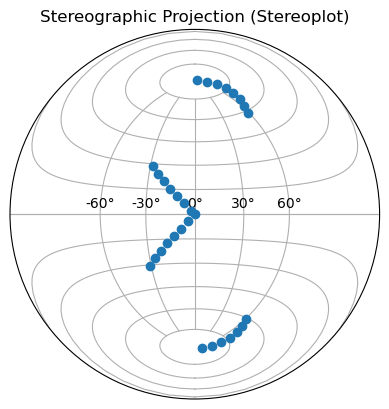

In [77]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.projections import register_projection
from matplotlib.projections.geo import LambertAxes
import numpy as np

import matplotlib as mpl
from matplotlib import _api
from matplotlib.axes import Axes
import matplotlib.axis as maxis
from matplotlib.patches import Circle
from matplotlib.path import Path
import matplotlib.spines as mspines
from matplotlib.ticker import (
    Formatter, NullLocator, FixedLocator, NullFormatter)
from matplotlib.transforms import Affine2D, BboxTransformTo, Transform

class GeoAxes(Axes):
    """An abstract base class for geographic projections."""

    class ThetaFormatter(Formatter):
        """
        Used to format the theta tick labels.  Converts the native
        unit of radians into degrees and adds a degree symbol.
        """
        def __init__(self, round_to=1.0):
            self._round_to = round_to

        def __call__(self, x, pos=None):
            degrees = round(np.rad2deg(x) / self._round_to) * self._round_to
            return f"{degrees:0.0f}\N{DEGREE SIGN}"

    RESOLUTION = 75

    def _init_axis(self):
        self.xaxis = maxis.XAxis(self, clear=False)
        self.yaxis = maxis.YAxis(self, clear=False)
        self.spines['geo'].register_axis(self.yaxis)

    def clear(self):
        # docstring inherited
        super().clear()

        self.set_longitude_grid(30)
        self.set_latitude_grid(15)
        self.set_longitude_grid_ends(75)
        self.xaxis.set_minor_locator(NullLocator())
        self.yaxis.set_minor_locator(NullLocator())
        self.xaxis.set_ticks_position('none')
        self.yaxis.set_ticks_position('none')
        self.yaxis.set_tick_params(label1On=True)
        # Why do we need to turn on yaxis tick labels, but
        # xaxis tick labels are already on?

        self.grid(mpl.rcParams['axes.grid'])

        Axes.set_xlim(self, -np.pi/2.0, np.pi/2.0)
        Axes.set_ylim(self, -np.pi / 2.0, np.pi / 2.0)

    def _set_lim_and_transforms(self):
        # A (possibly non-linear) projection on the (already scaled) data
        self.transProjection = self._get_core_transform(self.RESOLUTION)

        self.transAffine = self._get_affine_transform()

        self.transAxes = BboxTransformTo(self.bbox)

        # The complete data transformation stack -- from data all the
        # way to display coordinates
        self.transData = \
            self.transProjection + \
            self.transAffine + \
            self.transAxes

        # This is the transform for longitude ticks.
        self._xaxis_pretransform = \
            Affine2D() \
            .scale(1, self._longitude_cap * 2) \
            .translate(0, -self._longitude_cap)
        self._xaxis_transform = \
            self._xaxis_pretransform + \
            self.transData
        self._xaxis_text1_transform = \
            Affine2D().scale(1, 0) + \
            self.transData + \
            Affine2D().translate(0, 4)
        self._xaxis_text2_transform = \
            Affine2D().scale(1, 0) + \
            self.transData + \
            Affine2D().translate(0, -4)

        # This is the transform for latitude ticks.
        yaxis_stretch = Affine2D().scale(np.pi * 2, 1).translate(-np.pi, 0)
        yaxis_space = Affine2D().scale(1, 1.1)
        self._yaxis_transform = \
            yaxis_stretch + \
            self.transData
        yaxis_text_base = \
            yaxis_stretch + \
            self.transProjection + \
            (yaxis_space +
             self.transAffine +
             self.transAxes)
        self._yaxis_text1_transform = \
            yaxis_text_base + \
            Affine2D().translate(-8, 0)
        self._yaxis_text2_transform = \
            yaxis_text_base + \
            Affine2D().translate(8, 0)

    def _get_affine_transform(self):
        transform = self._get_core_transform(1)
        xscale, _ = transform.transform((np.pi, 0))
        _, yscale = transform.transform((0, np.pi/2))
        return Affine2D() \
            .scale(0.5 / xscale, 0.5 / yscale) \
            .translate(0.5, 0.5)

    def get_xaxis_transform(self, which='grid'):
        _api.check_in_list(['tick1', 'tick2', 'grid'], which=which)
        return self._xaxis_transform

    def get_xaxis_text1_transform(self, pad):
        return self._xaxis_text1_transform, 'bottom', 'center'

    def get_xaxis_text2_transform(self, pad):
        return self._xaxis_text2_transform, 'top', 'center'

    def get_yaxis_transform(self, which='grid'):
        _api.check_in_list(['tick1', 'tick2', 'grid'], which=which)
        return self._yaxis_transform

    def get_yaxis_text1_transform(self, pad):
        return self._yaxis_text1_transform, 'center', 'right'

    def get_yaxis_text2_transform(self, pad):
        return self._yaxis_text2_transform, 'center', 'left'

    def _gen_axes_patch(self):
        return Circle((0.5, 0.5), 0.5)

    def _gen_axes_spines(self):
        return {'geo': mspines.Spine.circular_spine(self, (0.5, 0.5), 0.5)}

    def set_yscale(self, *args, **kwargs):
        if args[0] != 'linear':
            raise NotImplementedError

    set_xscale = set_yscale

    def set_xlim(self, *args, **kwargs):
        """Not supported. Please consider using Cartopy."""
        raise TypeError("Changing axes limits of a geographic projection is "
                        "not supported.  Please consider using Cartopy.")

    set_ylim = set_xlim

    def format_coord(self, lon, lat):
        """Return a format string formatting the coordinate."""
        lon, lat = np.rad2deg([lon, lat])
        ns = 'N' if lat >= 0.0 else 'S'
        ew = 'E' if lon >= 0.0 else 'W'
        return ('%f\N{DEGREE SIGN}%s, %f\N{DEGREE SIGN}%s'
                % (abs(lat), ns, abs(lon), ew))

    def set_longitude_grid(self, degrees):
        """
        Set the number of degrees between each longitude grid.
        """
        # Skip -180 and 180, which are the fixed limits.
        grid = np.arange(-90 + degrees, 90, degrees)
        self.xaxis.set_major_locator(FixedLocator(np.deg2rad(grid)))
        self.xaxis.set_major_formatter(self.ThetaFormatter(degrees))

    def set_latitude_grid(self, degrees):
        """
        Set the number of degrees between each latitude grid.
        """
        # Skip -90 and 90, which are the fixed limits.
        grid = np.arange(-90 + degrees, 90, degrees)
        self.yaxis.set_major_locator(FixedLocator(np.deg2rad(grid)))
        self.yaxis.set_major_formatter(self.ThetaFormatter(degrees))

    def set_longitude_grid_ends(self, degrees):
        """
        Set the latitude(s) at which to stop drawing the longitude grids.
        """
        self._longitude_cap = np.deg2rad(degrees)
        self._xaxis_pretransform \
            .clear() \
            .scale(1.0, self._longitude_cap * 2.0) \
            .translate(0.0, -self._longitude_cap)

    def get_data_ratio(self):
        """Return the aspect ratio of the data itself."""
        return 1.0

    ### Interactive panning

    def can_zoom(self):
        """
        Return whether this Axes supports the zoom box button functionality.

        This Axes object does not support interactive zoom box.
        """
        return False

    def can_pan(self):
        """
        Return whether this Axes supports the pan/zoom button functionality.

        This Axes object does not support interactive pan/zoom.
        """
        return False

    def start_pan(self, x, y, button):
        pass

    def end_pan(self):
        pass

    def drag_pan(self, button, key, x, y):
        pass


class _GeoTransform(Transform):
    # Factoring out some common functionality.
    input_dims = output_dims = 2

    def __init__(self, resolution):
        """
        Create a new geographical transform.

        Resolution is the number of steps to interpolate between each input
        line segment to approximate its path in curved space.
        """
        super().__init__()
        self._resolution = resolution

    def __str__(self):
        return f"{type(self).__name__}({self._resolution})"

    def transform_path_non_affine(self, path):
        # docstring inherited
        ipath = path.interpolated(self._resolution)
        return Path(self.transform(ipath.vertices), ipath.codes)

        
class LambertAxes(GeoAxes):
    name = 'lambert'

    class LambertTransform(_GeoTransform):
        """The base Lambert transform."""

        def __init__(self, center_longitude, center_latitude, resolution):
            """
            Create a new Lambert transform.  Resolution is the number of steps
            to interpolate between each input line segment to approximate its
            path in curved Lambert space.
            """
            _GeoTransform.__init__(self, resolution)
            self._center_longitude = center_longitude
            self._center_latitude = center_latitude

        @_api.rename_parameter("3.8", "ll", "values")
        def transform_non_affine(self, values):
            # docstring inherited
            longitude, latitude = values.T
            clong = self._center_longitude
            clat = self._center_latitude
            cos_lat = np.cos(latitude)
            sin_lat = np.sin(latitude)
            diff_long = longitude - clong
            cos_diff_long = np.cos(diff_long)

            inner_k = np.maximum(  # Prevent divide-by-zero problems
                1 + np.sin(clat)*sin_lat + np.cos(clat)*cos_lat*cos_diff_long,
                1e-15)
            k = np.sqrt(2 / inner_k)
            x = k * cos_lat*np.sin(diff_long)
            y = k * (np.cos(clat)*sin_lat - np.sin(clat)*cos_lat*cos_diff_long)

            return np.column_stack([x, y])


    def __init__(self, *args, center_longitude=0, center_latitude=0, **kwargs):
        self._longitude_cap = np.pi / 2
        self._center_longitude = center_longitude
        self._center_latitude = center_latitude
        super().__init__(*args, **kwargs)
        self.set_aspect('equal', adjustable='box', anchor='C')
        self.clear()

    def clear(self):
        # docstring inherited
        super().clear()
        self.yaxis.set_major_formatter(NullFormatter())

    def _get_core_transform(self, resolution):
        return self.LambertTransform(
            self._center_longitude,
            self._center_latitude,
            resolution)

    def _get_affine_transform(self):
        return Affine2D() \
            .scale(0.256) \
            .translate(0.5, 0.5)
            
class Stereoplot(LambertAxes):
    name = "stereoplot"
    _default_center_latitude = 0
    _default_center_longitude = 0

    def __init__(self, *args, center_latitude=None, center_longitude=None, rotation=0, **kwargs):
        self.horizon = np.radians(90)
        self._rotation = -np.radians(rotation)

        center_latitude = center_latitude or self._default_center_latitude
        center_longitude = center_longitude or self._default_center_longitude

        kwargs["center_latitude"] = center_latitude
        kwargs["center_longitude"] = center_longitude
        
        super().__init__(*args, **kwargs)
    

register_projection(Stereoplot)

# Generate a sample stereonet projection plot
fig, ax = plt.subplots(subplot_kw=dict(projection="stereoplot"))

# Sample data for azimuth (0 to 360 degrees) and inclination (-90 to 90 degrees)
azimuth = np.linspace(0, 45, 30)
inclination = np.linspace(0, 45, 30)

# Plot the data on the stereonet
ax.plot(azimuth, inclination, 'o', label='Projection Points')
ax.set_title("Stereographic Projection (Stereoplot)")
# ax.legend()
plt.grid()
plt.show()

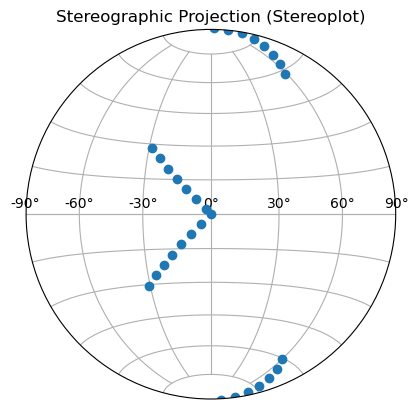

In [85]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.projections import register_projection
from matplotlib.projections.geo import LambertAxes
import numpy as np

import matplotlib as mpl
from matplotlib import _api
from matplotlib.axes import Axes
import matplotlib.axis as maxis
from matplotlib.patches import Circle
from matplotlib.path import Path
import matplotlib.spines as mspines
from matplotlib.ticker import (
    Formatter, NullLocator, FixedLocator, NullFormatter)
from matplotlib.transforms import Affine2D, BboxTransformTo, Transform


class HalfLambertAxes(LambertAxes, GeoAxes):
    def set_longitude_grid(self, degrees):
        """
        Set the number of degrees between each longitude grid.

        This is an example method that is specific to this projection
        class -- it provides a more convenient interface to set the
        ticking than set_xticks would.
        """

        grid = np.arange(-90, 90 + degrees, degrees)
        self.xaxis.set_major_locator(FixedLocator(np.deg2rad(grid)))
        self.xaxis.set_major_formatter(self.ThetaFormatter(degrees))

    def _get_affine_transform(self):
        return Affine2D() \
            .scale(0.356) \
            .translate(0.5, 0.5)
            
class Stereoplot(HalfLambertAxes):
    name = "stereoplot"
    _default_center_latitude = 0
    _default_center_longitude = 0

    def __init__(self, *args, center_latitude=None, center_longitude=None, rotation=0, **kwargs):
        self.horizon = np.radians(90)
        self._rotation = -np.radians(rotation)

        center_latitude = center_latitude or self._default_center_latitude
        center_longitude = center_longitude or self._default_center_longitude

        kwargs["center_latitude"] = center_latitude
        kwargs["center_longitude"] = center_longitude
        
        super().__init__(*args, **kwargs)
    

register_projection(Stereoplot)

# Generate a sample stereonet projection plot
fig, ax = plt.subplots(subplot_kw=dict(projection="stereoplot"))

# Sample data for azimuth (0 to 360 degrees) and inclination (-90 to 90 degrees)
azimuth = np.linspace(0, 45, 30)
inclination = np.linspace(0, 45, 30)

# Plot the data on the stereonet
ax.plot(azimuth, inclination, 'o', label='Projection Points')
ax.set_title("Stereographic Projection (Stereoplot)")
# ax.legend()
plt.grid()
plt.show()

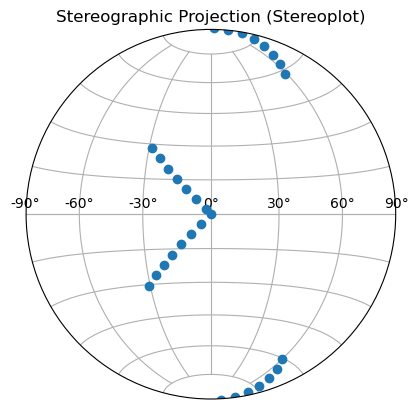

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.projections import register_projection
from matplotlib.projections.geo import LambertAxes
from matplotlib.ticker import FixedLocator
from matplotlib.transforms import Affine2D

class HalfLambertAxes(LambertAxes):
    def set_longitude_grid(self, degrees):
        """
        Set the number of degrees between each longitude grid.
        """
        grid = np.arange(-90, 90 + degrees, degrees)
        self.xaxis.set_major_locator(FixedLocator(np.deg2rad(grid)))
        self.xaxis.set_major_formatter(self.ThetaFormatter(degrees))

    def _get_affine_transform(self):
        return Affine2D().scale(0.356).translate(0.5, 0.5)

class Stereoplot(HalfLambertAxes):
    name = "stereoplot"
    _default_center_latitude = 0
    _default_center_longitude = 0

    def __init__(self, *args, center_latitude=None, center_longitude=None, rotation=0, **kwargs):
        self.horizon = np.radians(90)
        self._rotation = -np.radians(rotation)

        center_latitude = center_latitude or self._default_center_latitude
        center_longitude = center_longitude or self._default_center_longitude

        kwargs["center_latitude"] = center_latitude
        kwargs["center_longitude"] = center_longitude
        
        super().__init__(*args, **kwargs)

register_projection(Stereoplot)

# Generate a sample stereonet projection plot
fig, ax = plt.subplots(subplot_kw=dict(projection="stereoplot"))

# Sample data for azimuth (0 to 45 degrees) and inclination (0 to 45 degrees)
azimuth = np.linspace(0, 45, 30)
inclination = np.linspace(0, 45, 30)

# Plot the data on the stereonet
ax.plot(azimuth, inclination, 'o', label='Projection Points')
ax.set_title("Stereographic Projection (Stereoplot)")
plt.grid()
plt.show()


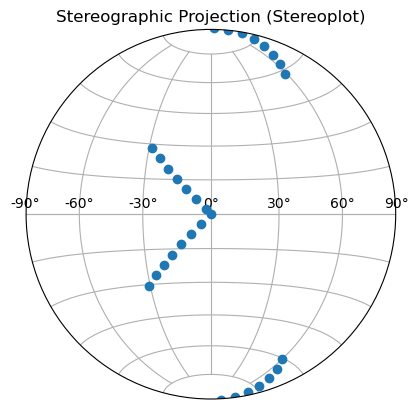

In [91]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.projections import register_projection
from matplotlib.projections.geo import LambertAxes
from matplotlib.ticker import FixedLocator
from matplotlib.transforms import Affine2D

class HalfLambertAxes(LambertAxes):
    """
    A custom projection class based on LambertAxes, representing a half-sphere projection.

    This class includes methods for configuring the grid and applying an affine transformation
    specific to the half-sphere Lambert projection.
    """

    def set_longitude_grid(self, degrees):
        """
        Sets the longitude grid interval.

        Parameters:
        ----------
        degrees : float
            The interval in degrees between each longitude grid line.
        
        This method sets up a grid with tick marks at specified longitude intervals, 
        using a fixed locator for the major ticks and a custom formatter.
        """
        grid = np.arange(-90, 90 + degrees, degrees)
        self.xaxis.set_major_locator(FixedLocator(np.deg2rad(grid)))
        self.xaxis.set_major_formatter(self.ThetaFormatter(degrees))

    def _get_affine_transform(self):
        """
        Returns an affine transformation for scaling and translating the half-sphere projection.

        Returns:
        -------
        Affine2D : Transformation for scaling and translating the plot within its axis limits.
        """
        return Affine2D().scale(0.356).translate(0.5, 0.5)

class Stereoplot(HalfLambertAxes):
    """
    A stereographic projection class for plotting data on a stereonet.

    Inherits from HalfLambertAxes to represent a stereographic view with options for specifying
    the center latitude, center longitude, and rotation. This projection is based on the `mplstereonet` project
    (https://github.com/joferkington/mplstereonet), which provides robust
    implementations for geological stereographic plots. This type of projection
    is valuable for visualizing orientation data in geoscience and related
    fields.
    """

    name = "stereoplot"
    _default_center_latitude = 0
    _default_center_longitude = 0

    def __init__(self, *args, center_latitude=None, center_longitude=None, rotation=0, **kwargs):
        """
        Initializes the Stereoplot projection with optional parameters for center and rotation.

        Parameters:
        ----------
        center_latitude : float, optional
            Latitude for the center of the projection, defaults to 0.
        center_longitude : float, optional
            Longitude for the center of the projection, defaults to 0.
        rotation : float, optional
            Rotation angle in degrees to apply to the projection, defaults to 0.
        """
        self.horizon = np.radians(90)
        self._rotation = -np.radians(rotation)

        center_latitude = center_latitude or self._default_center_latitude
        center_longitude = center_longitude or self._default_center_longitude

        kwargs["center_latitude"] = center_latitude
        kwargs["center_longitude"] = center_longitude
        
        super().__init__(*args, **kwargs)

register_projection(Stereoplot)

# Generate a sample stereonet projection plot
fig, ax = plt.subplots(subplot_kw=dict(projection="stereoplot"))

# Sample data for azimuth (0 to 45 degrees) and inclination (0 to 45 degrees)
azimuth = np.linspace(0, 45, 30)
inclination = np.linspace(0, 45, 30)

# Plot the data on the stereonet
ax.plot(azimuth, inclination, 'o', label='Projection Points')
ax.set_title("Stereographic Projection (Stereoplot)")
plt.grid()
plt.show()
